In [1]:
# P. Barry Seavey
# PRED 454-55, Winter 2018
# project 2
# kaggle.com 'Facial Keypoints Detection'

In [2]:
# CNN model with augmented data (NaN imputed w/ model2 predictions)

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.utils import shuffle

In [5]:
import os
print(os.listdir('../Facial Keypoints'))

['.ipynb_checkpoints', '15_pt_1.PNG', '4 Traditional White with Purple.pptx', '4_pt_1.PNG', 'clean-white-brick-wall-textures-plain-820x532.jpg', 'CNN2_128-500-500-30_augmentdata.h5', 'CNN2_128-500-500-30_dropout.h5', 'CNN2_128-500-500-30_v1.h5', 'CNN2_128-500-500-30_v5.h5', 'CNN_500-90-30_v2.h5', 'CNN_500-90-30_v5.h5', 'df_dump.PNG', 'face_model.h5', 'Fac_Kpt_1stCNNModel.ipynb', 'Fac_Kpt_1stModel.ipynb', 'Fac_Kpt_CNN-m2-flipnonull.ipynb', 'Fac_Kpt_CNN-model2-augmentdata.ipynb', 'Fac_Kpt_CNN-num2-dropout.ipynb', 'Fac_Kpt_CNN-num2.ipynb', 'Fac_Kpt_EDA1.ipynb', 'Fac_Kpt_img-extraction.ipynb', 'Fac_Kpt_nullpredict.ipynb', 'FKPt - imputedata1.ipynb', 'FKPt_CNN-batchnorm.ipynb', 'FKPt_CNN-m2-ensemble_augdata.ipynb', 'IdLookupTable.csv', 'imgs', 'KPT_500-90-30.h5', 'model2_augmentdata-v2.csv', 'model2_augmentdata.csv', 'model2_flipnonull.csv', 'model2_v1.csv', 'model2_withdrop.csv', 'nigel.jpg', 'nulldata.csv', 'pic1.png', 'SampleSubmission.csv', 'Screen_Caps', 'Seavey_base_500-90-30_v2.csv',

In [6]:
#

In [7]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/training_augmented2.csv'
FTEST = FROOT + '/test.csv'
FLOOKUP = FROOT + '/IdLookupTable.csv'

In [39]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test  : optional, defaults to `False`
            Flag indicating if we need to load from `FTEST` (`True`) or `FTRAIN` (`False`)
    cols  : optional, defaults to `None`
            A list of columns you're interested in. If specified only returns these columns.
               
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them
    columns = df.columns

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=123)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

In [9]:
def plt_sample(num):
    img = X[num].reshape(96, 96)
    #
    plt.imshow(img, cmap='gray')
    plt.scatter(y[num][0::2] * 48 + 48, y[num][1::2] * 48 + 48, marker='x', s=10, color='red')

In [10]:
X, y = load2d()  # loads train data only

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      7036
left_eye_inner_corner_y      7036
left_eye_outer_corner_x      7032
left_eye_outer_corner_y      7032
right_eye_inner_corner_x     7033
right_eye_inner_corner_y     7033
right_eye_outer_corner_x     7033
right_eye_outer_corner_y     7033
left_eyebrow_inner_end_x     7035
left_eyebrow_inner_end_y     7035
left_eyebrow_outer_end_x     6990
left_eyebrow_outer_end_y     6990
right_eyebrow_inner_end_x    7035
right_eyebrow_inner_end_y    7035
right_eyebrow_outer_end_x    7001
right_eyebrow_outer_end_y    7001
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          7034
mouth_left_corner_y          7034
mouth_right_corner_x         7035
mouth_right_corner_y         7035
mouth_center_top_lip_x       7040
mouth_center_top_lip_y       7040
mouth_center_bottom_lip_x    7026
mouth_center_b

In [11]:
X.shape

(6905, 96, 96, 1)

In [12]:
y.shape

(6905, 30)

In [10]:
# CNN for each group of features

In [13]:
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [16]:
#X = X.reshape(-1,96,96, 1)

In [17]:
#X.shape

(4621, 96, 96, 1)

In [18]:
y

array([[ 0.31135714, -0.24995001, -0.33985713, ...,  0.42725715,
         0.02894286,  0.63108569],
       [ 0.39154217, -0.19272289, -0.37304819, ...,  0.46956626,
         0.01463855,  0.70648193],
       [ 0.37710527, -0.21201342, -0.3164342 , ...,  0.48590994,
         0.05436842,  0.52272445],
       ..., 
       [ 0.40660843, -0.27268675, -0.37780121, ...,  0.52177709,
         0.02445783,  0.70950001],
       [ 0.3439562 , -0.19708247, -0.38539353, ...,  0.46793017,
         0.03137714,  0.63033146],
       [ 0.38568312, -0.25504577, -0.38986424, ...,  0.46909967,
         0.14705333,  0.59507334]], dtype=float32)

In [14]:
ENSEMBLE_GROUPS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        #flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        #flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        #flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [18]:
from collections import OrderedDict

In [23]:
from keras.optimizers import SGD

In [15]:
#from keras.preprocessing.image import ImageDataGenerator

In [37]:
#datagen = ImageDataGenerator(zca_whitening=True)
#datagen.fit(X)

C:\Users\Barry\Anaconda3\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4621, 96, 96, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [30]:
def fit_ensemble(
                    print_every=20,
                    epochs=50,
                    prop=0.1,
                    transfer_model='CNN2_128-500-500-30_augmentdata.h5'):
    specialists = OrderedDict()
 

    for setting in ENSEMBLE_GROUPS:
        
        cols = setting['columns']
        
        X, y = load2d(cols=cols)
        #X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          #test_size=0.2, 
                                                          #random_state=123)

        model=SimpleCNN()    
        model.layers.pop() # get rid of output layer
        model.outputs = [model.layers[-1].output]
        model.layers[-1].outbound_nodes = []
        model.add(Dense(len(cols))) # add new output layer

        model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
        #model.summary()
        hist = model.fit(X, y, validation_split=0.2, epochs=epochs, verbose=1, callbacks=[checkpointer])     
        specialists[cols] = {"model":model,"hist":hist}
        
    return(specialists)

In [16]:
checkpointer = ModelCheckpoint(filepath='CNN2_128-500-500-30_ensemb-augment.h5', verbose=1, save_best_only=True)

In [31]:
%%time
ensemble1 = fit_ensemble(print_every=20,
                    epochs=50,
                    transfer_model='CNN2_128-500-500-30_augmentdata.h5')

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Train on 5626 samples, validate on 1407 samples
Epoch 1/50
5626/5626 [==============================] - 96s - loss: 0.0146 - acc: 0.9788 - val_loss: 0.0038 - val_acc: 0.9950
Epoch 2/50
5626/5626 [==============================] - 93s - loss: 0.0030 - acc: 0.9957 - val_loss: 0.0031 - val_acc: 0.9950
Epoch 3/50
5626/5626 [==============================] - 91s - loss: 0.0025 - acc: 0.9957 - val_loss: 0.0026 - val_acc: 0.9950
Epoch 4/50
5626/5626 [==============================] - 91s - loss: 0.0021 - acc: 0.9957 - val_loss: 0.0024 - val_acc: 0.9957
Epoch 5/50
5626/5626 [==============================] - 91s - loss: 0.0018 - acc: 0.9968 - val_loss: 0.0025 - val_acc: 0.9957
Epoch 6/50
5626/5626 [==============================] - 92s - loss: 0.0015 - acc: 0.9966 - val_loss: 0.0023 - val_acc: 0.9964
Epoch 7/50
5626/5626 [==========================

5626/5626 [==============================] - 94s - loss: 2.6557e-04 - acc: 0.9989 - val_loss: 0.0020 - val_acc: 0.9950
Epoch 29/50
5626/5626 [==============================] - 94s - loss: 2.5701e-04 - acc: 0.9982 - val_loss: 0.0019 - val_acc: 0.9950
Epoch 30/50
5626/5626 [==============================] - 93s - loss: 2.9590e-04 - acc: 0.9993 - val_loss: 0.0020 - val_acc: 0.9957
Epoch 31/50
5626/5626 [==============================] - 93s - loss: 2.3245e-04 - acc: 0.9988 - val_loss: 0.0020 - val_acc: 0.9957
Epoch 32/50
5626/5626 [==============================] - 93s - loss: 2.2125e-04 - acc: 0.9989 - val_loss: 0.0019 - val_acc: 0.9943
Epoch 33/50
5626/5626 [==============================] - 93s - loss: 2.2874e-04 - acc: 0.9984 - val_loss: 0.0019 - val_acc: 0.9950
Epoch 34/50
5626/5626 [==============================] - 92s - loss: 3.0660e-04 - acc: 0.9979 - val_loss: 0.0020 - val_acc: 0.9950
Epoch 35/50
5626/5626 [==============================] - 94s - loss: 2.5575e-04 - acc: 0.9995 -

5639/5639 [==============================] - 102s - loss: 0.0016 - acc: 0.9878 - val_loss: 0.0037 - val_acc: 0.9830
Epoch 10/50
5639/5639 [==============================] - 102s - loss: 0.0014 - acc: 0.9888 - val_loss: 0.0038 - val_acc: 0.9851
Epoch 11/50
5639/5639 [==============================] - 102s - loss: 0.0012 - acc: 0.9890 - val_loss: 0.0035 - val_acc: 0.9837
Epoch 12/50
5639/5639 [==============================] - 102s - loss: 0.0010 - acc: 0.9913 - val_loss: 0.0035 - val_acc: 0.9844
Epoch 13/50
5639/5639 [==============================] - 102s - loss: 8.6058e-04 - acc: 0.9917 - val_loss: 0.0033 - val_acc: 0.9858
Epoch 14/50
5639/5639 [==============================] - 102s - loss: 7.7376e-04 - acc: 0.9926 - val_loss: 0.0033 - val_acc: 0.9858
Epoch 15/50
5639/5639 [==============================] - 102s - loss: 6.5803e-04 - acc: 0.9918 - val_loss: 0.0034 - val_acc: 0.9851
Epoch 16/50
5639/5639 [==============================] - 103s - loss: 6.8197e-04 - acc: 0.9931 - val_los

5639/5639 [==============================] - 91s - loss: 3.7873e-04 - acc: 0.9954 - val_loss: 0.0033 - val_acc: 0.9823
Epoch 42/50
5639/5639 [==============================] - 92s - loss: 3.8561e-04 - acc: 0.9957 - val_loss: 0.0031 - val_acc: 0.9844
Epoch 43/50
5639/5639 [==============================] - 91s - loss: 4.9181e-04 - acc: 0.9950 - val_loss: 0.0034 - val_acc: 0.9816
Epoch 44/50
5639/5639 [==============================] - 91s - loss: 4.6535e-04 - acc: 0.9943 - val_loss: 0.0031 - val_acc: 0.9851
Epoch 45/50
5639/5639 [==============================] - 91s - loss: 3.8518e-04 - acc: 0.9959 - val_loss: 0.0030 - val_acc: 0.9837
Epoch 46/50
5639/5639 [==============================] - 91s - loss: 3.4659e-04 - acc: 0.9952 - val_loss: 0.0033 - val_acc: 0.9830
Epoch 47/50
5639/5639 [==============================] - 91s - loss: 3.5466e-04 - acc: 0.9961 - val_loss: 0.0031 - val_acc: 0.9844
Epoch 48/50
5639/5639 [==============================] - 91s - loss: 3.5043e-04 - acc: 0.9952 -

5620/5620 [==============================] - 91s - loss: 2.9026e-04 - acc: 0.8699 - val_loss: 0.0011 - val_acc: 0.8192
Epoch 21/50
5620/5620 [==============================] - 91s - loss: 2.7962e-04 - acc: 0.8742 - val_loss: 9.9221e-04 - val_acc: 0.8313
Epoch 22/50
5620/5620 [==============================] - 91s - loss: 2.5525e-04 - acc: 0.8776 - val_loss: 9.3945e-04 - val_acc: 0.8541
Epoch 23/50
5620/5620 [==============================] - 91s - loss: 2.4279e-04 - acc: 0.8804 - val_loss: 9.4075e-04 - val_acc: 0.8406
Epoch 24/50
5620/5620 [==============================] - 91s - loss: 2.3903e-04 - acc: 0.8820 - val_loss: 9.6966e-04 - val_acc: 0.8434
Epoch 25/50
5620/5620 [==============================] - 90s - loss: 2.3246e-04 - acc: 0.8847 - val_loss: 9.9856e-04 - val_acc: 0.8128
Epoch 26/50
5620/5620 [==============================] - 91s - loss: 2.2807e-04 - acc: 0.8868 - val_loss: 9.6311e-04 - val_acc: 0.8349
Epoch 27/50
5620/5620 [==============================] - 91s - loss: 1.

5620/5620 [==============================] - 91s - loss: 1.5786e-04 - acc: 0.9146 - val_loss: 9.2588e-04 - val_acc: 0.8420
mouth_center_bottom_lip_x    7026
mouth_center_bottom_lip_y    7026
Image                        7049
dtype: int64
Train on 5620 samples, validate on 1406 samples
Epoch 1/50
5620/5620 [==============================] - 91s - loss: 0.0242 - acc: 0.9973 - val_loss: 0.0092 - val_acc: 0.9993
Epoch 2/50
5620/5620 [==============================] - 90s - loss: 0.0064 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9993
Epoch 3/50
5620/5620 [==============================] - 91s - loss: 0.0049 - acc: 0.9989 - val_loss: 0.0049 - val_acc: 0.9993
Epoch 4/50
5620/5620 [==============================] - 91s - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0046 - val_acc: 0.9993
Epoch 5/50
5620/5620 [==============================] - 91s - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9993
Epoch 6/50
5620/5620 [==============================] - 91s - loss: 0.0029 - acc: 0.

5620/5620 [==============================] - 91s - loss: 3.8445e-04 - acc: 0.9998 - val_loss: 0.0039 - val_acc: 0.9993
Epoch 33/50
5620/5620 [==============================] - 91s - loss: 3.9854e-04 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9993
Epoch 34/50
5620/5620 [==============================] - 90s - loss: 4.2611e-04 - acc: 0.9998 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 35/50
5620/5620 [==============================] - 91s - loss: 4.6568e-04 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9986
Epoch 36/50
5620/5620 [==============================] - 91s - loss: 4.3430e-04 - acc: 0.9995 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 37/50
5620/5620 [==============================] - 91s - loss: 3.8762e-04 - acc: 0.9998 - val_loss: 0.0045 - val_acc: 0.9993
Epoch 38/50
5620/5620 [==============================] - 91s - loss: 3.9597e-04 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 39/50
5620/5620 [==============================] - 91s - loss: 5.3352e-04 - acc: 0.9995 -

5609/5609 [==============================] - 91s - loss: 3.1390e-04 - acc: 0.9998 - val_loss: 6.7573e-04 - val_acc: 1.0000
Epoch 12/50
5609/5609 [==============================] - 91s - loss: 2.7436e-04 - acc: 0.9998 - val_loss: 6.9173e-04 - val_acc: 1.0000
Epoch 13/50
5609/5609 [==============================] - 91s - loss: 2.4054e-04 - acc: 0.9998 - val_loss: 6.3005e-04 - val_acc: 1.0000
Epoch 14/50
5609/5609 [==============================] - 90s - loss: 2.1311e-04 - acc: 0.9998 - val_loss: 6.3285e-04 - val_acc: 1.0000
Epoch 15/50
5609/5609 [==============================] - 91s - loss: 2.0108e-04 - acc: 1.0000 - val_loss: 6.7640e-04 - val_acc: 1.0000
Epoch 16/50
5609/5609 [==============================] - 91s - loss: 1.8745e-04 - acc: 0.9998 - val_loss: 6.3625e-04 - val_acc: 1.0000
Epoch 17/50
5609/5609 [==============================] - 91s - loss: 1.8651e-04 - acc: 0.9998 - val_loss: 6.2032e-04 - val_acc: 1.0000
Epoch 18/50
5609/5609 [==============================] - 91s - loss

5609/5609 [==============================] - 92s - loss: 5.7085e-05 - acc: 0.9998 - val_loss: 5.9534e-04 - val_acc: 1.0000
Epoch 42/50
5609/5609 [==============================] - 93s - loss: 5.8614e-05 - acc: 1.0000 - val_loss: 6.0417e-04 - val_acc: 1.0000
Epoch 43/50
5609/5609 [==============================] - 93s - loss: 6.2311e-05 - acc: 1.0000 - val_loss: 6.0462e-04 - val_acc: 1.0000
Epoch 44/50
5609/5609 [==============================] - 92s - loss: 6.4852e-05 - acc: 1.0000 - val_loss: 6.0833e-04 - val_acc: 1.0000
Epoch 45/50
5609/5609 [==============================] - 93s - loss: 6.1014e-05 - acc: 0.9998 - val_loss: 5.9459e-04 - val_acc: 1.0000
Epoch 46/50
5609/5609 [==============================] - 91s - loss: 5.7868e-05 - acc: 0.9998 - val_loss: 6.1739e-04 - val_acc: 1.0000
Epoch 47/50
5609/5609 [==============================] - 90s - loss: 5.9650e-05 - acc: 1.0000 - val_loss: 6.0909e-04 - val_acc: 1.0000
Epoch 48/50
5609/5609 [==============================] - 91s - loss

5564/5564 [==============================] - 90s - loss: 2.5058e-04 - acc: 0.9998 - val_loss: 8.3044e-04 - val_acc: 1.0000
Epoch 22/50
5564/5564 [==============================] - 90s - loss: 2.1002e-04 - acc: 1.0000 - val_loss: 8.1646e-04 - val_acc: 1.0000
Epoch 23/50
5564/5564 [==============================] - 90s - loss: 1.8583e-04 - acc: 1.0000 - val_loss: 7.7861e-04 - val_acc: 1.0000
Epoch 24/50
5564/5564 [==============================] - 90s - loss: 1.8030e-04 - acc: 1.0000 - val_loss: 8.0543e-04 - val_acc: 1.0000
Epoch 25/50
5564/5564 [==============================] - 90s - loss: 1.7309e-04 - acc: 1.0000 - val_loss: 8.1442e-04 - val_acc: 1.0000
Epoch 26/50
5564/5564 [==============================] - 90s - loss: 1.7797e-04 - acc: 1.0000 - val_loss: 8.3948e-04 - val_acc: 1.0000
Epoch 27/50
5564/5564 [==============================] - 90s - loss: 1.6836e-04 - acc: 1.0000 - val_loss: 7.8628e-04 - val_acc: 1.0000
Epoch 28/50
5564/5564 [==============================] - 90s - loss

In [20]:
from keras.optimizers import SGD

In [20]:
def SimpleCNN(withDropout=False):

    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2))) 
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01, momentum = 0.9, nesterov=True)
    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
    return(model)

In [54]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

TypeError: 'History' object is not subscriptable

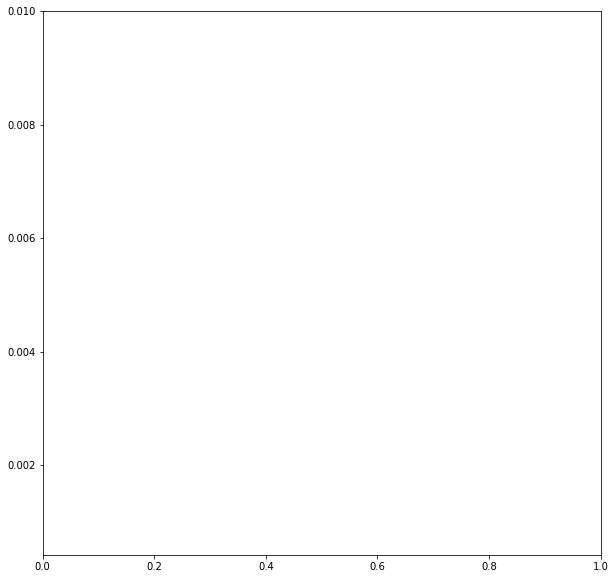

In [55]:
def plot_specialist(ensemble1,plt):
    
    i = 1
    for key , value in ensemble1.items():
        plot_loss(value["hist"],key[0] + str(len(key)),plt)
        i += 1

    plt.legend()
    plt.grid()
    plt.set_yscale("log")
    plt.set_xlabel("epoch")
    plt.set_ylabel("loss")
  
fig = plt.figure(figsize=(10,10))  
ax = fig.add_subplot(1,1,1)
ax.set_ylim(7**(-4),10**(-2))
plot_specialist(ensemble1,ax)
plt.show()

In [40]:
X_test, _ = load2d(test=True)

ImageId    1783
Image      1783
dtype: int64


In [41]:
X_test.shape

(1783, 96, 96, 1)

In [70]:
#X_test=X_test.reshape(-1, 96, 96, 1)

In [71]:
#X_test.shape

(1783, 96, 96, 1)

In [45]:
#model.load_weights("CNN_500-90-30_v2.h5")
#y_test = model2.predict(X_test)
#print(y_test.shape)

(1783, 30)


In [60]:
def predict_specialist(ensemble1,X_test):
    y_pred_s = []
    for columns, value in ensemble1.items():
        smodel = value["model"]

        y_pred = smodel.predict(X_test)
        y_pred = pd.DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = pd.concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(ensemble1,X_test)
y_pred_s = df_y_pred_s.values

In [61]:
df_y_pred_s.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,...,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y
0,0.346744,-0.210476,-0.376158,-0.233894,0.022856,0.084875,0.317433,0.570622,-0.313587,0.576917,...,-0.502736,-0.233721,0.166594,-0.426769,-0.253352,-0.478812,0.657658,-0.391735,-0.687521,-0.436261
1,0.387593,-0.233662,-0.417304,-0.209321,0.023133,0.247660,0.388599,0.613795,-0.294633,0.623696,...,-0.549563,-0.195817,0.166465,-0.373910,-0.233445,-0.365397,0.678865,-0.415244,-0.708462,-0.342800
2,0.376838,-0.248682,-0.369799,-0.206728,0.028912,0.186015,0.327476,0.558647,-0.241493,0.577848,...,-0.488341,-0.189530,0.203470,-0.372348,-0.150897,-0.354981,0.585317,-0.386353,-0.576623,-0.299111
3,0.373778,-0.186883,-0.336747,-0.151869,-0.010208,0.088394,0.361992,0.637790,-0.292911,0.643257,...,-0.487395,-0.144626,0.174964,-0.346684,-0.219242,-0.350920,0.597371,-0.355895,-0.627774,-0.299031
4,0.408596,-0.218463,-0.387125,-0.194736,0.027062,0.195286,0.341237,0.633546,-0.293555,0.616261,...,-0.518253,-0.187454,0.200952,-0.436845,-0.184634,-0.412528,0.659156,-0.414385,-0.659784,-0.336676


In [63]:
IdLookup = pd.read_csv('../Facial Keypoints/IdLookupTable.csv')

def prepare_submission(y_pred,filename):

    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,df_y_pred_s[landmark].iloc[irow-1]])
    
    submit = pd.DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    loc = "../Facial Keypoints/" + filename + ".csv"
    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
    
prepare_submission(y_pred_s,"CNN_ensemble_augment")

(27124, 2)
File is saved at:../Facial Keypoints/CNN_ensemble_augment.csv


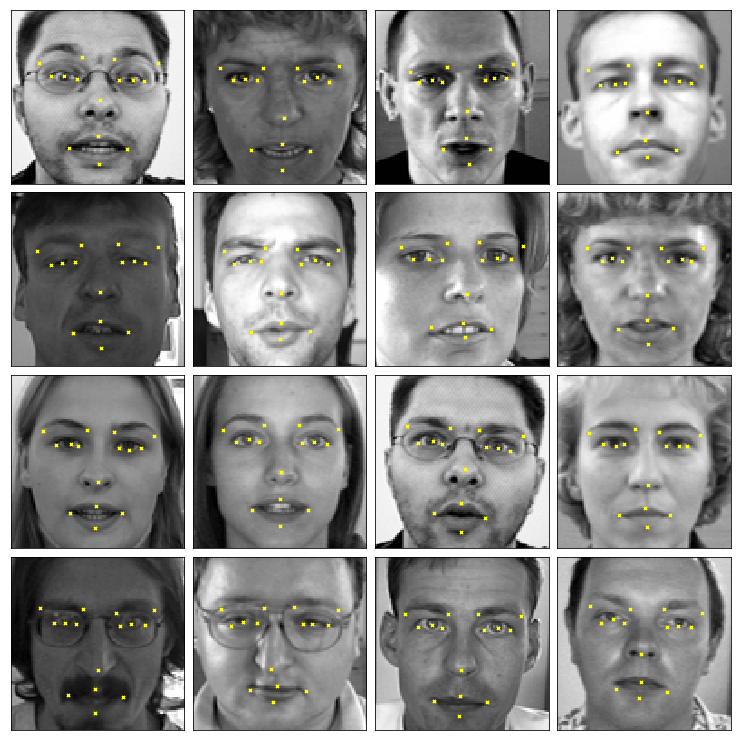

In [76]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred2[i], axis)

plt.show()

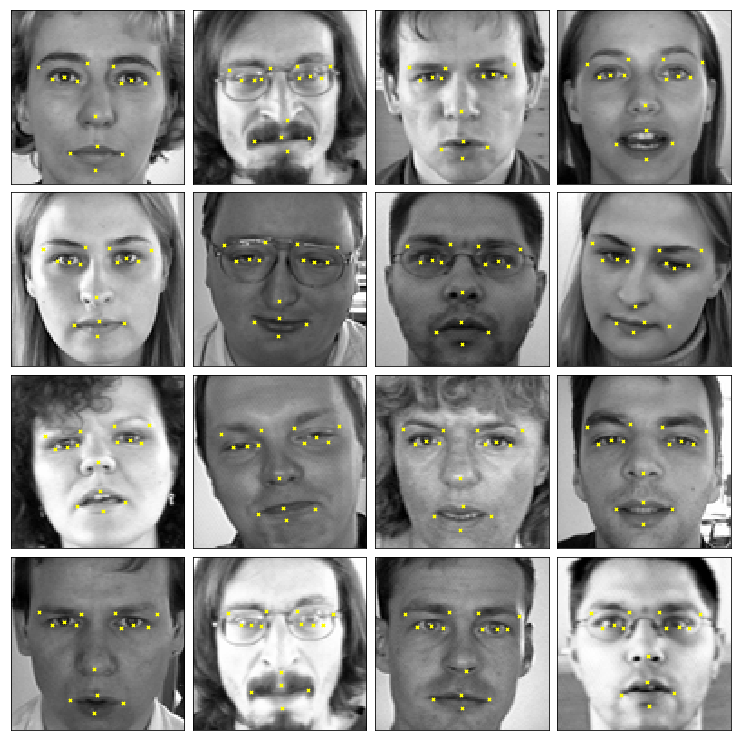

In [77]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+16], y_pred2[i+16], axis)

plt.show()

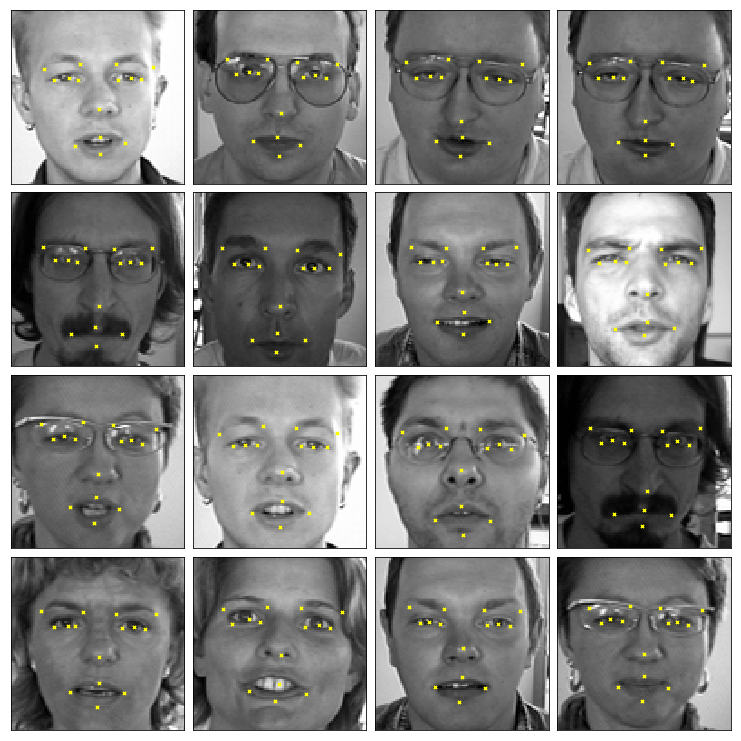

In [78]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+80], y_pred2[i+80], axis)

plt.show()

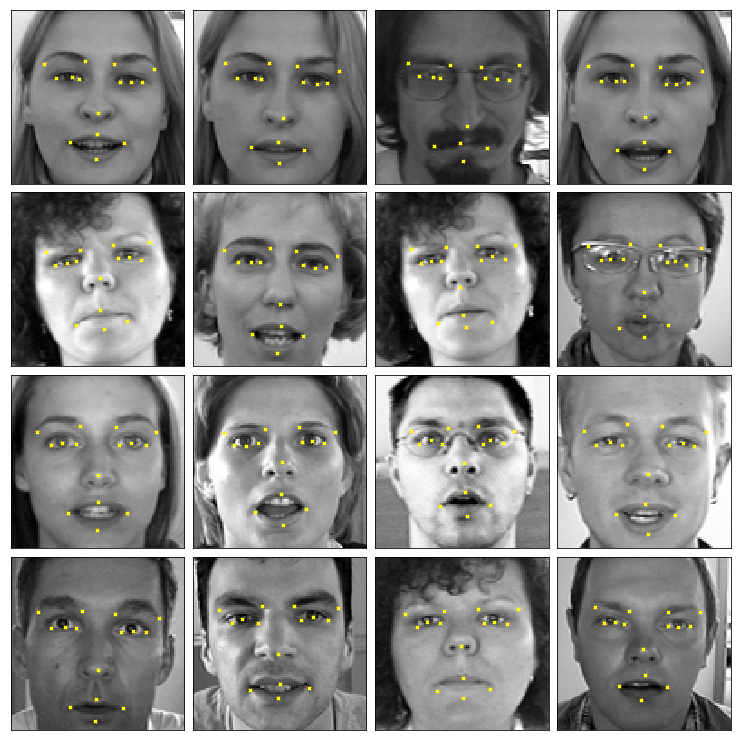

In [79]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i+200], y_pred2[i+200], axis)

plt.show()